In [1]:
import logging
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt
from bmws import Observation, sim_and_fit, sim_wf
from bmws.betamix import Dataset, forward, BetaMixture
from bmws.estimate import empirical_bayes, estimate, jittable_estimate, _beta_pdf
from bmws.sim import sim_admix
rng = np.random.default_rng()


INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


In [2]:
#This block is just reading in the data, sorry it's a bit gross 

#Load EAS data
admixture_proportions=pd.read_csv("admixture_proportions.txt", sep="\t")
admixture_proportions["generation"]=[int(x) for x in round(admixture_proportions["Date"]/30)]
admixture_proportions=admixture_proportions[(admixture_proportions['Date'] <=10000)]

#merge allele counts 
counts=pd.read_csv("snp_acs.raw", sep="\t")
data=pd.merge(admixture_proportions, counts, on="IID")

#Spread present-day samples randomly over last 10 generations, for computational efficiency. 
for i in range(data.shape[0]):
    if data.iloc[i, data.columns.get_loc('generation')]==0:
        data.iloc[i, data.columns.get_loc('generation')]=rng.choice(10)

#Parameters for data matrices
T=max(data["generation"])+1
N=max(data["generation"].value_counts().values)

#Which SNP to look at
snp="rs7925299_C(/G)"

#Create data matrices
obs = np.zeros([T, N, 2], dtype=int)
samples = np.zeros([T, N], dtype=int)
#thetas = np.zeros([T, N, 3], dtype=float)
thetas = rng.dirichlet(np.ones(3), [T, N])

#Fill in data matrices (in simplest way possible) - generation, N
for gen,count in data["generation"].value_counts().items():
    this_data=data[data["generation"]==gen]
    M=this_data.shape[0]
    for i in range(M):
        if not this_data[snp].isna().iloc[i]:
            thetas[gen,i,0]=this_data["North"].iloc[i]
            thetas[gen,i,1]=this_data["South"].iloc[i]
            #thetas[gen,i,2]=this_data["Jomon"].iloc[i]
            thetas[gen,i,2]=1.0-thetas[gen,i,1]-thetas[gen,i,0]
            obs[gen,i,0]=1
            obs[gen,i,1]=this_data[snp].values[i]/2
            samples[gen,i]=1
        else:
            thetas[gen,i,0]=1.0
            thetas[gen,i,1]=0.0
            thetas[gen,i,2]=0.0
            
data, nzi = Dataset(thetas=thetas, obs=obs).resort()

In [3]:
#Run analysis - this fails; after the first iteration all s values are nan
em_iterations=1
M=100
Ne=np.zeros([T - 1, data.K]) + 10000
Ne_fit=Ne
s = np.zeros([T - 1, data.K])
ab = np.ones([2, data.K]) + 1e-4
estimate_kwargs={"lam": 1e4, "gamma": 0.0}

for i in range(em_iterations):
    logger.info("EM iteration %d", i)
    ab, prior = empirical_bayes(ab0=ab, s=s, data=data, nzi=nzi, Ne=Ne, M=M)
    logger.info("ab: %s", ab)
    s = estimate(data=data, Ne=Ne_fit, prior=prior, nzi=nzi, **estimate_kwargs)
    logger.info("s: %s", s)

betas, _ = forward(s, Ne, data, nzi, prior)


INFO:__main__:EM iteration 0


(Array([[1.0001, 1.0001, 1.0001],
       [1.0001, 1.0001, 1.0001]], dtype=float64), Array([[100., 100., 100.],
       [100., 100., 100.]], dtype=float64))
Traced<ShapedArray(float64[])>with<JVPTrace(level=3/1)> with
  primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/1)>
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=2/1)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f809fbef4c0>, in_tracers=(Traced<ShapedArray(float64[]):JaxprTrace(level=2/1)>, Traced<ShapedArray(float64[]):JaxprTrace(level=2/1)>), out_tracer_refs=[<weakref at 0x7f80a61058f0; to 'JaxprTracer' at 0x7f80a6106110>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[] b:f64[]. let c:f64[] = div a b in (c,) }, 'in_shardings': (UnspecifiedValue, UnspecifiedValue), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False, False), 'name': 'true_divide', 'keep_unused': F

INFO:__main__:ab: [[nan nan nan]
 [nan nan nan]]
INFO:__main__:s: [[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [na

In [4]:
print(s)

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan 

In [5]:
#Replace observations with random alleles with frequency 50%
#This runs fine. 

obs2 = np.zeros([T, N, 2], dtype=int)
for t in range(T):
    for n in range(N):
        a = obs[t, n, 0]
        d = rng.binomial(a, 0.5)
        obs2[t, n] = [a, d]
data, nzi = Dataset(thetas=thetas, obs=obs2).resort()

em_iterations=1
M=100
Ne=np.zeros([T - 1, data.K]) + 10000
Ne_fit=Ne
s = np.zeros([T - 1, data.K])
ab = np.ones([2, data.K]) + 1e-4
estimate_kwargs={"lam": 1e4, "gamma": 0.0}

for i in range(em_iterations):
    logger.info("EM iteration %d", i)
    ab, prior = empirical_bayes(ab0=ab, s=s, data=data, nzi=nzi, Ne=Ne, M=M)
    logger.info("ab: %s", ab)
    s = estimate(data=data, Ne=Ne_fit, prior=prior, nzi=nzi, **estimate_kwargs)
    logger.info("s: %s", s)

betas, _ = forward(s, Ne, data, nzi, prior)


INFO:__main__:EM iteration 0


(Array([[1.0001, 1.0001, 1.0001],
       [1.0001, 1.0001, 1.0001]], dtype=float64), Array([[100., 100., 100.],
       [100., 100., 100.]], dtype=float64))


INFO:__main__:ab: [[5.29461894 2.64172744 4.37462081]
 [3.33416059 3.60412513 4.00596843]]
INFO:__main__:s: [[-2.06679845e-02 -2.03636720e-02 -6.76139556e-03]
 [-2.06257574e-02 -2.03668435e-02 -6.75911878e-03]
 [-2.05039310e-02 -2.02651576e-02 -6.75411355e-03]
 [-2.02724677e-02 -2.00488605e-02 -6.74809358e-03]
 [-1.98986606e-02 -1.97748914e-02 -6.73494853e-03]
 [-1.95369167e-02 -1.95354872e-02 -6.72600098e-03]
 [-1.91033284e-02 -1.92840755e-02 -6.71728342e-03]
 [-1.86040792e-02 -1.90150209e-02 -6.71062200e-03]
 [-1.80583811e-02 -1.88132962e-02 -6.69775418e-03]
 [-1.75505854e-02 -1.86256080e-02 -6.68203960e-03]
 [-1.69974263e-02 -1.84390451e-02 -6.66262181e-03]
 [-1.64762878e-02 -1.82548105e-02 -6.64354748e-03]
 [-1.59465555e-02 -1.80681113e-02 -6.62184318e-03]
 [-1.54271405e-02 -1.78887162e-02 -6.59952339e-03]
 [-1.49080727e-02 -1.77040641e-02 -6.57574442e-03]
 [-1.43893711e-02 -1.75257768e-02 -6.55011962e-03]
 [-1.38814179e-02 -1.73420672e-02 -6.52440466e-03]
 [-1.33642183e-02 -1.7168

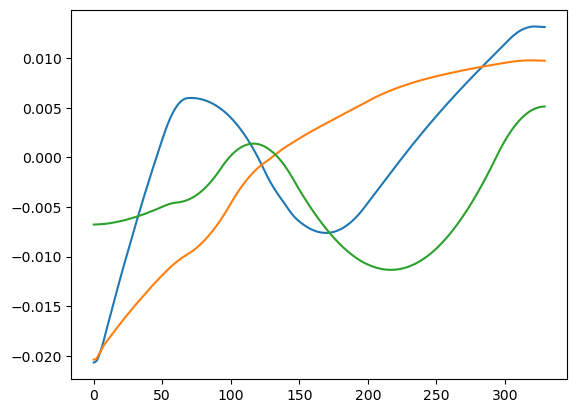

In [6]:
plt.plot(s[:, 0], color="tab:blue", alpha=1)
plt.plot(s[:, 1], color="tab:orange", alpha=1)
plt.plot(s[:, 2], color="tab:green", alpha=1)